# Mean Field Inference

In [17]:
import numpy as np
from mlxtend.data import loadlocal_mnist
import matplotlib.pyplot as plt
import operator
from sklearn import metrics

In [2]:
# load MNIST images

ims, _ = loadlocal_mnist(
        images_path='train-images-idx3-ubyte', 
        labels_path='train-labels-idx1-ubyte')


In [4]:
# find 8 neighbors of a given pixel

def find_neighbor(im, idx, w, h):
    s = w*h
    nbr = []
    if idx < 0 or idx > s-1:
        return nbr
    if idx-1 >= 0 and idx%w != 0:
        nbr.append(idx-1)
    if idx+1 < s and (idx+1)%w != 0:
        nbr.append(idx+1)
    if idx-w >= 0:
        nbr.append(idx-w)
    if idx+w < s:
        nbr.append(idx+w)
    if idx-w-1 >= 0 and idx%w != 0:
        nbr.append(idx-w-1)
    if idx-w+1 >= 0 and (idx+1)%w != 0:
        nbr.append(idx-w+1)
    if idx+w-1 < s and idx%w != 0:
        nbr.append(idx+w-1)
    if idx+w+1 < s and (idx+1)%w != 0:
        nbr.append(idx+w+1)
    return nbr


In [6]:
# Update an image using mean field inference until it converges(update<delta)

def update_image(im, theta_h, theta_x, pi_i, delta, run_time):
    temp_im = im.copy()
    temp_pi_i = pi_i.copy()
    diff = 0
    for p in range(im.shape[0]):
        nbr = find_neighbor(im, p, 28, 28)
        q_plus = 0
        q_minus = 0
        for n in nbr:
            q_plus += theta_h * (2*pi_i[n] - 1) + theta_x * im[n]
            q_minus += -q_plus
        temp_pi_i[p] = np.exp(q_plus)/(np.exp(q_plus)+np.exp(q_minus))
        if abs(temp_pi_i[p] - pi_i[p]) > diff:
            diff = abs(temp_pi_i[p] - pi_i[p])
        if temp_pi_i[p] > 0.5:
            temp_im[p] = 1
        else:
            temp_im[p] = -1
    im = temp_im
    pi_i = temp_pi_i
    if diff > delta and run_time < 15:
        update_image(im, theta_h, theta_x, pi_i, delta, run_time+1)
    return im, pi_i

In [73]:
# take the first 500 MNIST images as original images and denoise 2% pixels randomly

im_in = ims[0:500][:]/255.0
im_noise = im_in.copy()
rand_idx = np.arange(im_in.shape[1])
for i in range(im_in.shape[0]):
    for j in range(im_in.shape[1]):
        if im_in[i][j]>=0.5:
            im_in[i][j] = 1
            im_noise[i][j] = 1
        else:
            im_in[i][j] = -1
            im_noise[i][j] = -1
    np.random.shuffle(rand_idx)
    for k in range(int(len(rand_idx)*0.02)):
        p = rand_idx[k]
        im_noise[i][p]*=-1
        

In [74]:
# reconstruct images

pi = np.ones((im_in.shape[0], im_in.shape[1]))*0.5
im_out = im_noise.copy()
delta = 0.00001
run_time = 0
for i in range(im_out.shape[0]):
    im_out[i], pi[i]= update_image_old(im_out[i], 0.2, 0.2, pi[i], delta)

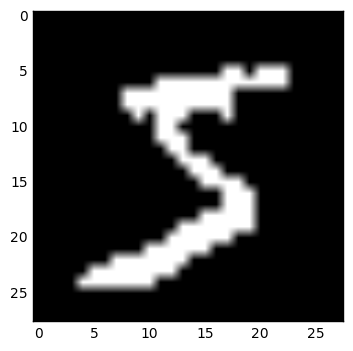

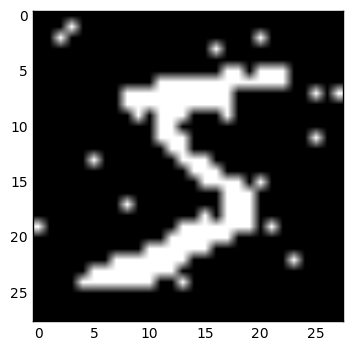

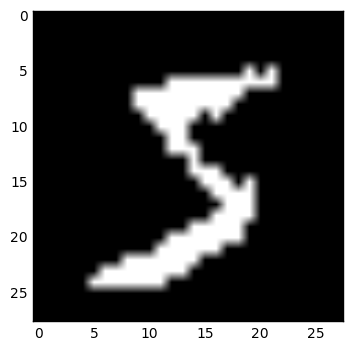

In [48]:
# plot original, noised, denoised images
# replace this image to be most&least accurate reconstructions    
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 10
for i in range(10):
    plt.figure()
    plt.imshow(im_in[i].reshape(28,28), cmap="gray")
    plt.figure()
    plt.imshow(im_noise[i].reshape(28,28), cmap="gray")
    plt.figure()
    plt.imshow(im_out[i].reshape(28,28), cmap="gray")
plt.show() 

In [71]:
### TO DO: find the most&least accurate reconstructions and plot original, noised, denoised images
def get_accuracy(test):
    total_accuracy = np.zeros(im_in.shape[0])
    for i in range(im_in.shape[0]):
        wrong = 0
        curr = im_in[i]
        compare = test[i]
        for j in range(curr.shape[0]):
            if curr[j] != compare[j]:
                   wrong += 1
        accuracy = 1 - 1.0 * (wrong)/curr.shape[0]
        total_accuracy[i] = accuracy
    average_accuracy = sum(total_accuracy)/500
    print(average_accuracy)
    return average_accuracy

In [75]:
e = get_accuracy(im_out)

0.965918367347


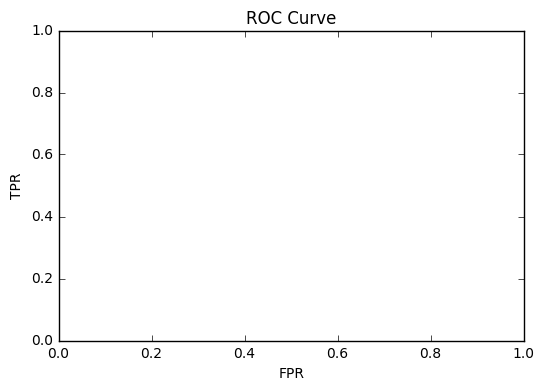

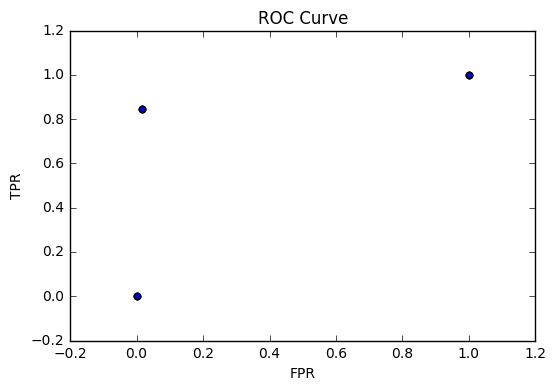

In [61]:
parameters = [-1, 0, 0.2, 1, 2]

label = im_in.reshape(500 * 784)
plt.figure()
fpr = {}
plt = {}
for para in parameters:
    fpr[para],tpr[para], _ = metrics.roc_curve(label, pred[para])
    plt.scatter(fpr[para], tpr[para]) 
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

In [33]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==-1:
           TN += 1
        if y_hat[i]==-1 and y_actual[i]!=y_hat[i]:
           FN += 1
    TPR = 1.0 * TP / (TP + FN)
    FPR = 1.0 * FP / (FP + TN)
    return(TPR, FPR, TP, FP, TN, FN)

In [37]:
TPR = []
FPR = []
pred = {}

In [ ]:
(42171, 5652, 336428, 7749)
[0.8447716346153846, 0.84609375, 0.8452524038461539, 0.844931891025641, 0.8454126602564103]
[0.016522450888681012, 0.016563376987839103, 0.016484448082319924, 0.0166072263797942, 0.016519527595884004]

In [58]:
pred[2] = im_out.copy().reshape(500 * 784)

a, b, c, d, e,f = perf_measure(label, pred[2])
TPR.append(a)
FPR.append(b)
print(c, d, e, f)
print(TPR)
print(FPR)

(42203, 5651, 336429, 7717)
[0.8447716346153846, 0.84609375, 0.8452524038461539, 0.844931891025641, 0.844931891025641, 0.8454126602564103]
[0.016522450888681012, 0.016563376987839103, 0.016484448082319924, 0.0166072263797942, 0.0166072263797942, 0.016519527595884004]


-1
0
0.2
1
2


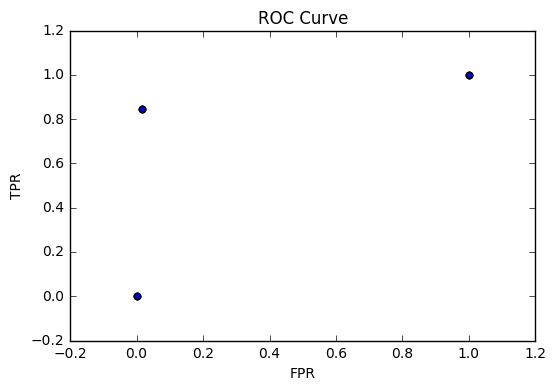

In [27]:
### TO DO: plot receiving operating curve -1, 0, 0.2, 1, 2

parameters = [-1, 0, 0.2, 1, 2]
pred = {}
label = im_in.reshape(500 * 784)
plt.figure()

fpr = dict()
tpr = dict()

for para in parameters:

    pi = np.ones((im_in.shape[0], im_in.shape[1]))*0.5
    im_out = im_noise.copy()
    delta = 0.001
    for i in range(im_out.shape[0]):
        if para == -1:
            im_out[i], pi[i]= update_image(im_out[i], -1, 0.2, pi[i], delta, 0)
        else:
            im_out[i], pi[i]= update_image_old(im_out[i], para, 0.2, pi[i], delta)
    pred[para] = im_out.reshape(500 * 784).copy()
    fpr[para],tpr[para], _ = metrics.roc_curve(label, pred[para])
    plt.scatter(fpr[para], tpr[para])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()
    

In [22]:

# Update an image using mean field inference until it converges(update<delta)

def update_image_old(im, theta_h, theta_x, pi_i, delta):
    temp_im = im.copy()
    temp_pi_i = pi_i.copy()
    diff = 0
    for p in range(im.shape[0]):
        nbr = find_neighbor(im, p, 28, 28)
        q_plus = 0
        q_minus = 0
        for n in nbr:
            q_plus += 0.2 * (2*pi_i[n] - 1 + im[n])
            q_minus += -q_plus
        temp_pi_i[p] = np.exp(q_plus)/(np.exp(q_plus)+np.exp(q_minus))
        if abs(temp_pi_i[p] - pi_i[p]) > diff:
            diff = abs(temp_pi_i[p] - pi_i[p])
        if temp_pi_i[p] > 0.5:
            temp_im[p] = 1
        else:
            temp_im[p] = -1
    im = temp_im
    pi_i = temp_pi_i
    if diff > delta:
        update_image_old(im, theta_h, theta_x, pi_i, delta)
    return im, pi_i

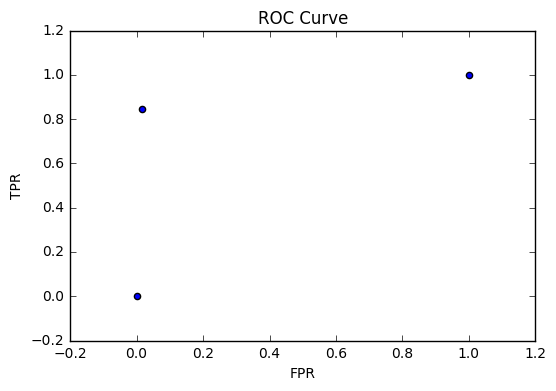

In [20]:
pred = {}
label = im_in.reshape(500 * 784)
fpr = dict()
tpr = dict()
pred[-1] = im_out.reshape(500 * 784)
fpr[-1],tpr[-1], _ = metrics.roc_curve(label, pred[-1])
plt.scatter(fpr[-1], tpr[-1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

[ 0.95408163  0.97066327  0.96811224  0.98086735  0.96683673  0.9502551
  0.98341837  0.96938776  0.98596939  0.96683673  0.96938776  0.97193878
  0.96428571  0.95918367  0.9872449   0.96683673  0.95790816  0.95663265
  0.93494898  0.97576531  0.97066327  0.97193878  0.95408163  0.97704082
  0.96938776  0.95408163  0.96428571  0.96428571  0.96683673  0.98086735
  0.95918367  0.96938776  0.95790816  0.96938776  0.9744898   0.96683673
  0.97321429  0.9630102   0.96938776  0.9630102   0.98979592  0.96173469
  0.9744898   0.96045918  0.96683673  0.96556122  0.92729592  0.97193878
  0.96556122  0.96173469  0.95790816  0.96938776  0.96683673  0.95280612
  0.9630102   0.94897959  0.9630102   0.96938776  0.97066327  0.97831633
  0.96428571  0.95790816  0.96428571  0.96811224  0.95918367  0.97321429
  0.9744898   0.97321429  0.93494898  0.96045918  0.97576531  0.97321429
  0.98341837  0.94897959  0.96938776  0.96428571  0.96428571  0.97959184
  0.98086735  0.96683673  0.95408163  0.97193878  0.

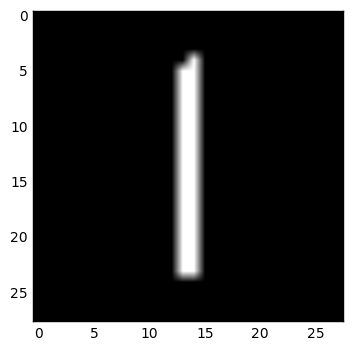

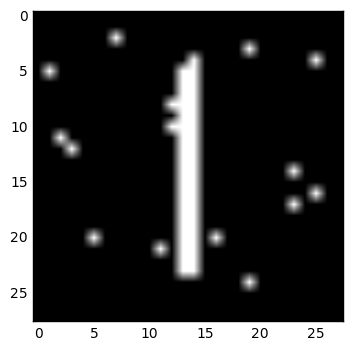

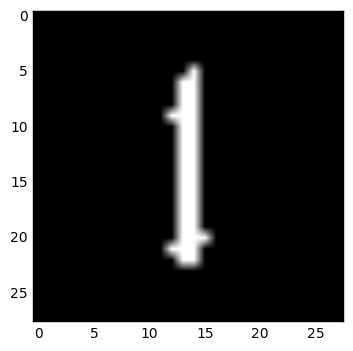

In [77]:
# best reconstruction

total_accuracy = np.zeros(im_in.shape[0])
for i in range(im_in.shape[0]):
    wrong = 0
    curr = im_in[i]
    compare = im_out[i]
    for j in range(curr.shape[0]):
        if curr[j] != compare[j]:
               wrong += 1
    accuracy = 1 - 1.0 * (wrong)/curr.shape[0]
    total_accuracy[i] = accuracy
    
average_accuracy = sum(total_accuracy)/500
print(total_accuracy)

best, value = max(enumerate(total_accuracy), key=operator.itemgetter(1))
print(value)
plt.figure()
plt.imshow(im_in[best].reshape(28,28), cmap="gray")
plt.figure()
plt.imshow(im_noise[best].reshape(28,28), cmap="gray")
plt.figure()
plt.imshow(im_out[best].reshape(28,28), cmap="gray")
plt.show()

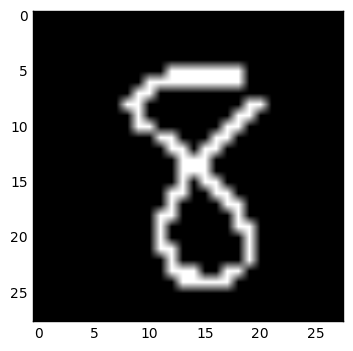

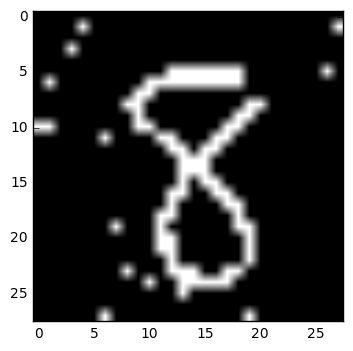

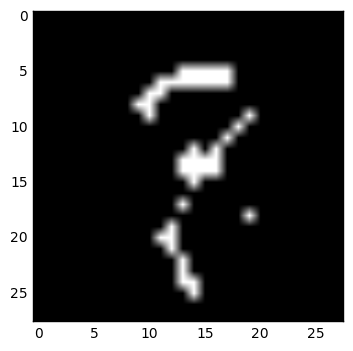

In [16]:
# worst reconstruction

worst, value = min(enumerate(total_accuracy), key=operator.itemgetter(1))
plt.figure()
plt.imshow(im_in[worst].reshape(28,28), cmap="gray")
plt.figure()
plt.imshow(im_noise[worst].reshape(28,28), cmap="gray")
plt.figure()
plt.imshow(im_out[worst].reshape(28,28), cmap="gray")
plt.show()

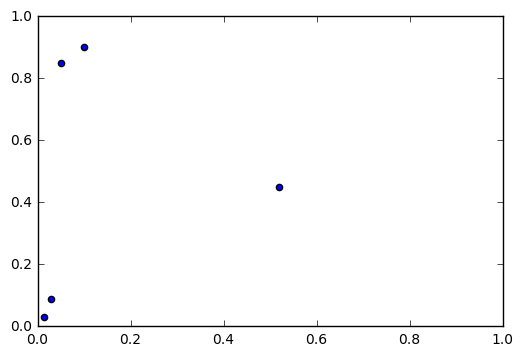

In [64]:
plt.figure
plt.xlim(0,1)
plt.ylim(0,1)
x = [0.52, 0.05, 0.1, 0.014, 0.028]
y = [0.45, 0.85, 0.90, 0.03, 0.09]
plt.scatter(x, y)
plt.show()